In [1]:
pip install mlflow

In [2]:
#import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set( )
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = "plotly_white"
from plotly.offline import init_notebook_mode, iplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Seed for reproducibility
SEED = np.random.seed(seed = 2023)

In [4]:
from scipy.io import arff
data_path = "Bank_Marketing_Dataset.arff"

In [5]:
#import the dataset
#data = arff.loadarff(data_path)["data"]

In [6]:
def truncate_data(data):
  if data.isdigit():
    return int(data)
  else:
    if "." in data:
      try:
        return float(data)
      except:
        return data
    return data

def truncate_row(row):
  return [truncate_data(data) for data in row]

In [7]:
# def read_data(data_path):
#   with open(data_path, "r") as f:
#     lines = f.readlines()

#     #Get column names
#     columns = [
#         lines.split(" ")[1] for line in lines if line.startswith("@ATTRIBUTE")
#     ]

#     ix = 0
#     for (i, line) in enumerate(lines):
#       if line.startswith("@DATA"):
#         ix = i
#         break
#     lines = lines[ix+1:]
#     data = [
#         truncate_row(row.replace("\n", "").strip().split(",")) for row in lines
#     ]

#     data = [row for row in data if len(row) == len(columns)]

#     return pd.DataFrame(data = data, columns=columns)

def read_data(data_path):
    with open(data_path, "r") as f:
        # Read all lines at once
        content = f.read()
        lines = content.split('\n')  # Split the content into lines

        #Get column names
        columns = [
            line.split(" ")[1] for line in lines if line.startswith("@ATTRIBUTE")
        ]

        ix = 0
        for (i, line) in enumerate(lines):
            if line.startswith("@DATA"):
                ix = i
                break
        lines = lines[ix+1:]
        data = [
            truncate_row(row.replace("\n", "").strip().split(",")) for row in lines
        ]

        data = [row for row in data if len(row) == len(columns)]

        return pd.DataFrame(data = data, columns=columns)

In [8]:
# Read data
data = read_data(data_path)

In [9]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  object
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(5), object(12)
memory usage: 1.4+ MB


In [11]:
# convert features to correct datatypes
for column in data.select_dtypes("object").columns:
  try:
    data[column] = data[column].astype("int")
  except:
    pass


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int32 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int32 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int32(2), int64(5), object(10)
memory usage: 1.4+ MB


In [13]:
#Feature cardinality
data.nunique()

age            76
job            12
marital         3
education       4
default         2
balance      3805
housing         2
loan            2
contact         3
day            31
month          12
duration     1428
campaign       36
pdays         472
previous       34
poutcome        4
deposit         2
dtype: int64

In [14]:
# Describe data
data.describe(include = "all")

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
count,11162.000000,11162,11162,11162,11162,11162.000000,11162,11162,11162,11162.000000,11162,11162.000000,11162.000000,11162.000000,11162.000000,11162,11162
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,management,married,secondary,no,NaN,no,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,2566,6351,5476,10994,NaN,5881,9702,8042,NaN,2824,NaN,NaN,NaN,NaN,8326,5873
mean,41.231948,NaN,NaN,NaN,NaN,1528.538524,NaN,NaN,NaN,15.658036,NaN,371.993818,2.508421,51.330407,0.832557,NaN,NaN
std,11.913369,NaN,NaN,NaN,NaN,3225.413326,NaN,NaN,NaN,8.420740,NaN,347.128386,2.722077,108.758282,2.292007,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-6847.000000,NaN,NaN,NaN,1.000000,NaN,2.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,32.000000,NaN,NaN,NaN,NaN,122.000000,NaN,NaN,NaN,8.000000,NaN,138.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,550.000000,NaN,NaN,NaN,15.000000,NaN,255.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,49.000000,NaN,NaN,NaN,NaN,1708.000000,NaN,NaN,NaN,22.000000,NaN,496.000000,3.000000,20.750000,1.000000,NaN,NaN


In [15]:
#check for missing values
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [16]:
# check for duplicates
duplicates = len(data[data.duplicated()])
duplicates

0

EXPLORATORY DATA ANALYSIS

#### Customer occupation and ages

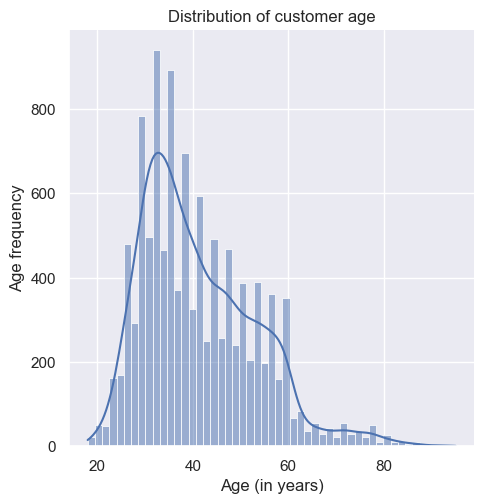

In [19]:
# Distribution of customer age

sns.displot(data = data, x = "age", kde = True)

plt.title("Distribution of customer age")

plt.xlabel("Age (in years)")
plt.ylabel("Age frequency")

plt.show(); plt.close("all")

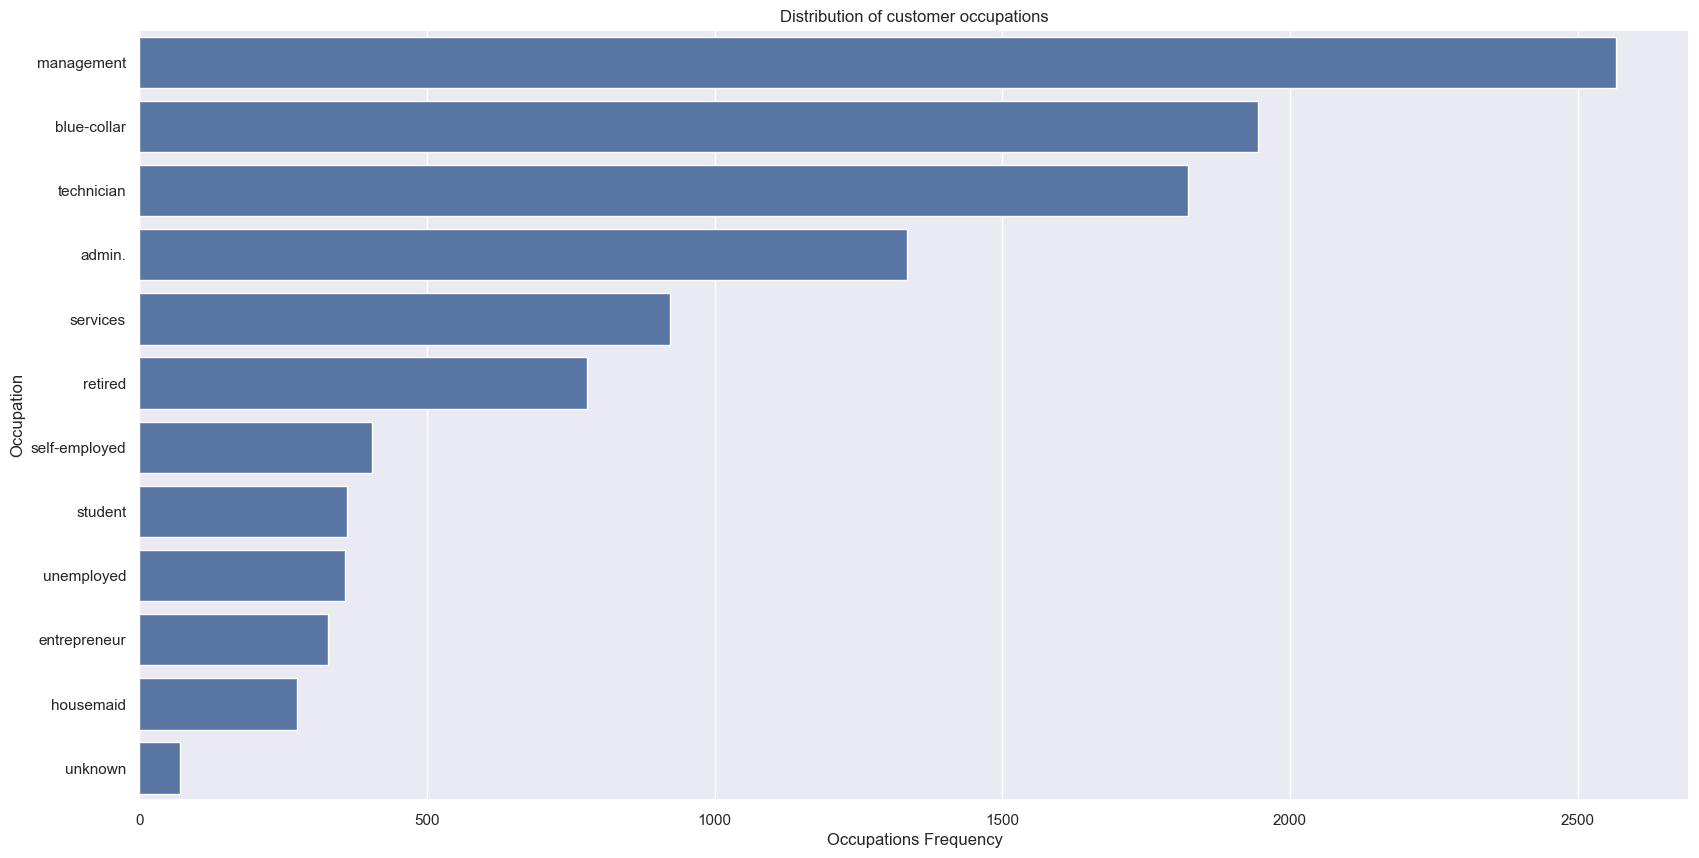

In [20]:
# Distribution of customer occupation

plt.figure(figsize = (20, 10))

job_order = data["job"].value_counts().sort_values(ascending=False).index

sns.countplot(data["job"],  order=job_order)

plt.title("Distribution of customer occupations")

plt.xlabel("Occupations Frequency")
plt.ylabel("Occupation")

plt.show(); plt.close("all")

In [21]:
# Categorize ages
hue = data["age"].apply(lambda x: "Working age" if x < 60 else "Retirement age")

age_job = data[["job"]].copy()
age_job["hue"] = hue.values

In [22]:
age_job.head()

,job,hue
0,admin.,Working age
1,admin.,Working age
2,technician,Working age
3,services,Working age
4,admin.,Working age


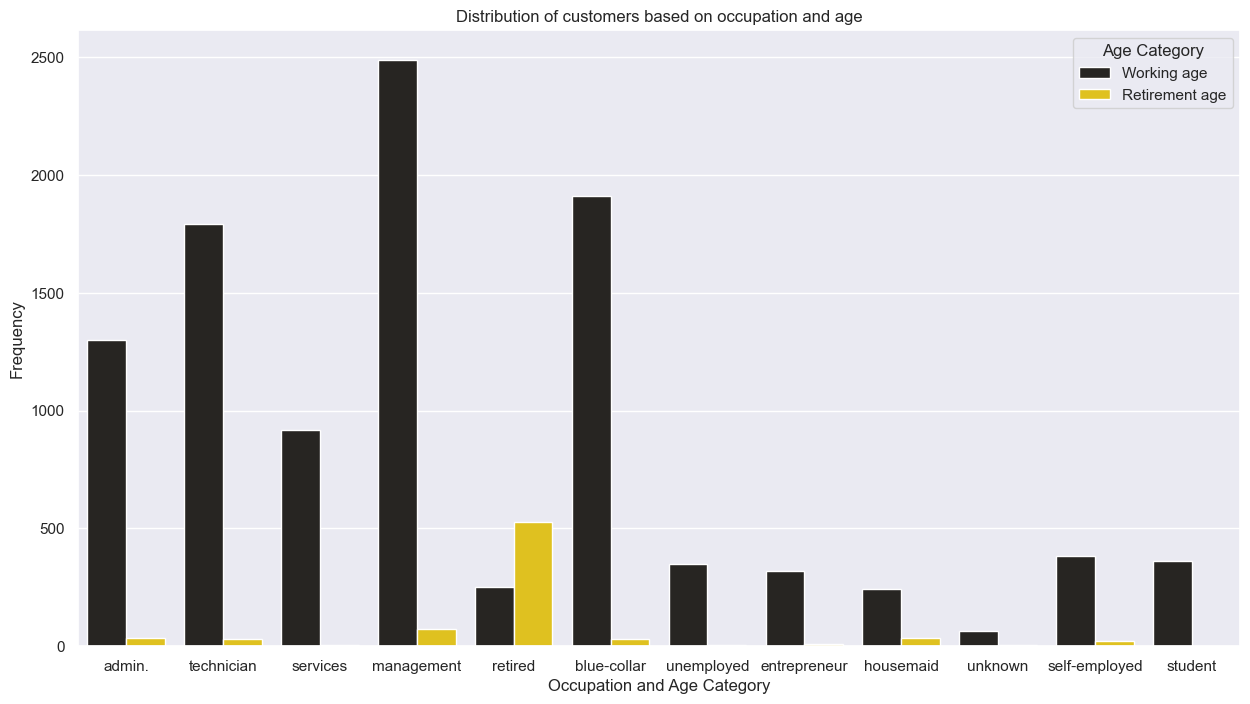

In [23]:
# Occupation and age
plt.figure(figsize = (15, 8))

sns.countplot(data = age_job, x = "job", hue = "hue", palette  = "dark:gold")

plt.title("Distribution of customers based on occupation and age")

plt.xlabel("Occupation and Age Category")
plt.ylabel("Frequency")

plt.legend(title = "Age Category")
plt.show(); plt.close("all")

#### Personal Loans(loan) and credit status(default)

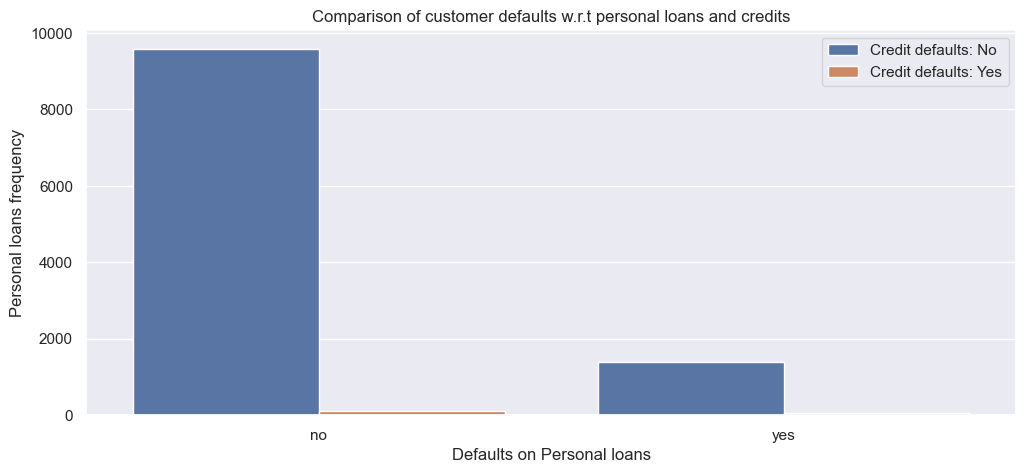

In [25]:
plt.figure(figsize = (12, 5))

sns.countplot(data = data, x = "loan", hue = "default")

plt.title("Comparison of customer defaults w.r.t personal loans and credits")

plt.xlabel("Defaults on Personal loans")
plt.ylabel("Personal loans frequency")
plt.legend(["Credit defaults: No", "Credit defaults: Yes"])
plt.show(); plt.close("all")

#### Personal loans (loan) and housing loan status (housing)

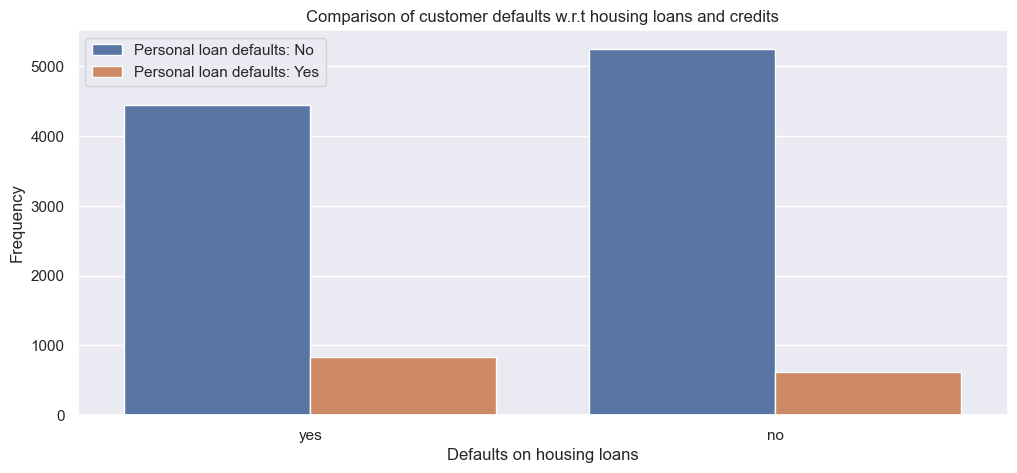

In [27]:
plt.figure(figsize = (12, 5))

sns.countplot(data = data, x = "housing", hue = "loan")

plt.title("Comparison of customer defaults w.r.t housing loans and credits")

plt.xlabel("Defaults on housing loans")
plt.ylabel("Frequency")
plt.legend(["Personal loan defaults: No", "Personal loan defaults: Yes"])
plt.show(); plt.close("all")

#### Comparism between types of debt and marital status

Comparism between types of marital status and credit defaults

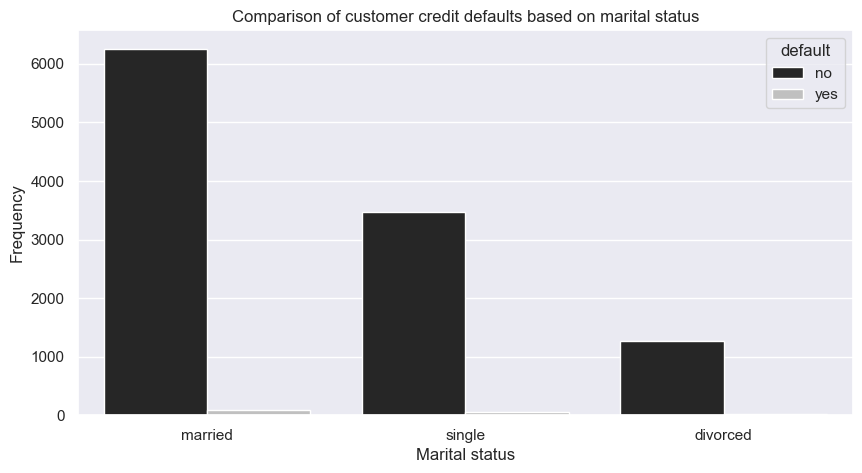

In [30]:
# Marital status and credit defaults
plt.figure(figsize = (10, 5))

sns.countplot(data = data, x = "marital", hue = "default", palette  = "dark:silver")

plt.title("Comparison of customer credit defaults based on marital status")

plt.xlabel("Marital status")
plt.ylabel("Frequency")

#plt.legend(title = "Age Category")
plt.show(); plt.close("all")

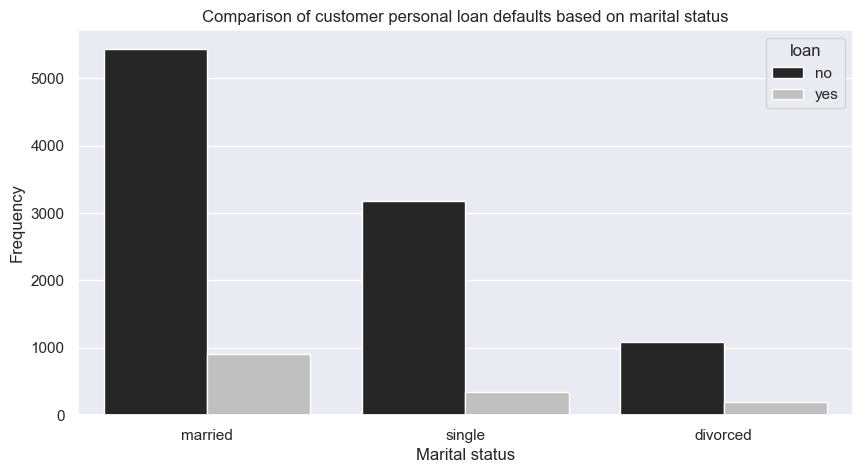

In [31]:
# Marital status and personal loandefaults
plt.figure(figsize = (10, 5))

sns.countplot(data = data, x = "marital", hue = "loan", palette  = "dark:silver")

plt.title("Comparison of customer personal loan defaults based on marital status")

plt.xlabel("Marital status")
plt.ylabel("Frequency")

#plt.legend(title = "Age Category")
plt.show(); plt.close("all")

Comparism between types of marital status and housing loans defaults

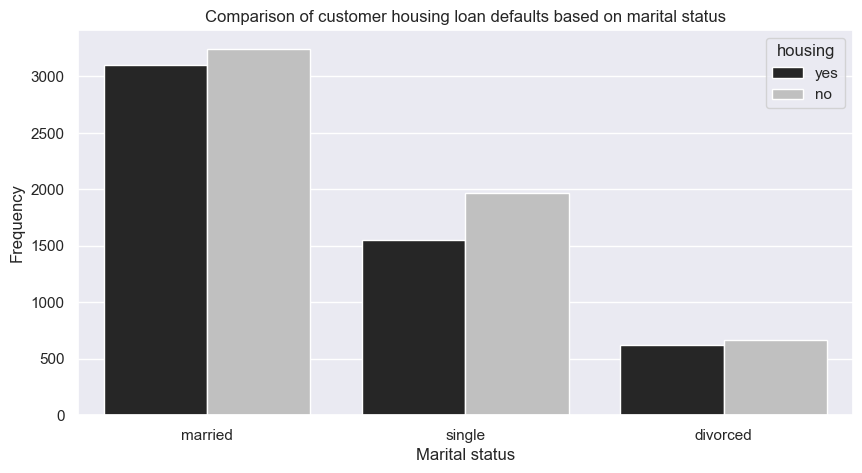

In [33]:
# Marital status and housing loandefaults
plt.figure(figsize = (10, 5))

sns.countplot(data = data, x = "marital", hue = "housing", palette  = "dark:silver")

plt.title("Comparison of customer housing loan defaults based on marital status")

plt.xlabel("Marital status")
plt.ylabel("Frequency")

#plt.legend(title = "Age Category")
plt.show(); plt.close("all")

In [34]:
data["marital"].value_counts(normalize=True)

marital
married     0.568984
single      0.315176
divorced    0.115839
Name: proportion, dtype: float64

Comparism between types of debt and deposit decision

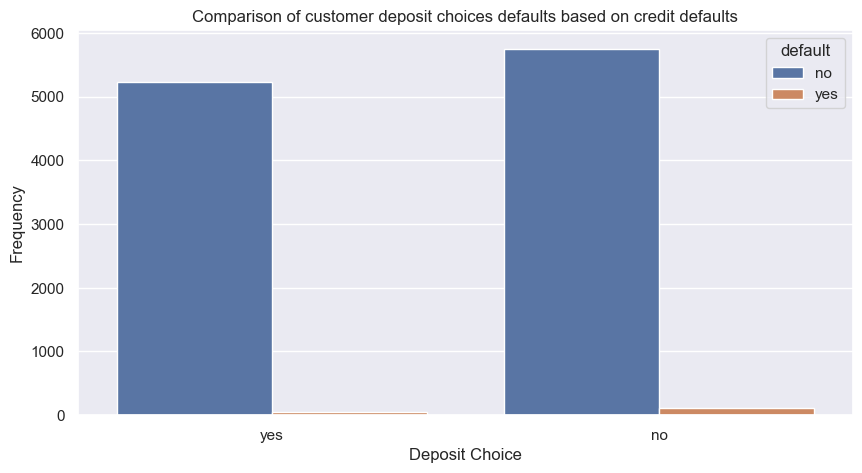

In [36]:
# Deposit choice and credit defaults


plt.figure(figsize = (10, 5))

sns.countplot(data = data, x = "deposit", hue = "default")

plt.title("Comparison of customer deposit choices defaults based on credit defaults")

plt.xlabel("Deposit Choice")
plt.ylabel("Frequency")

#plt.legend(title = "Age Category")
plt.show(); plt.close("all")


Comparism between personal loan and deposit decision

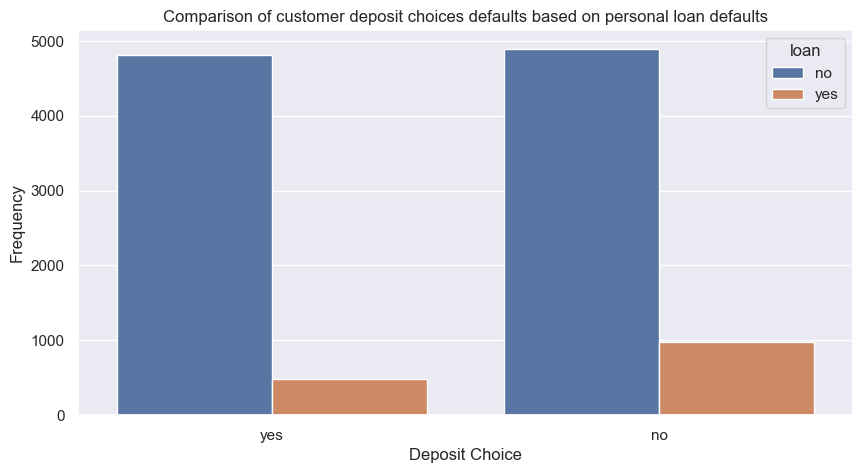

In [38]:
# Deposit choice and credit defaults

plt.figure(figsize = (10, 5))

sns.countplot(data = data, x = "deposit", hue = "loan")

plt.title("Comparison of customer deposit choices defaults based on personal loan defaults")

plt.xlabel("Deposit Choice")
plt.ylabel("Frequency")

#plt.legend(title = "Age Category")
plt.show(); plt.close("all")


Comparism between housing loan and deposit decision

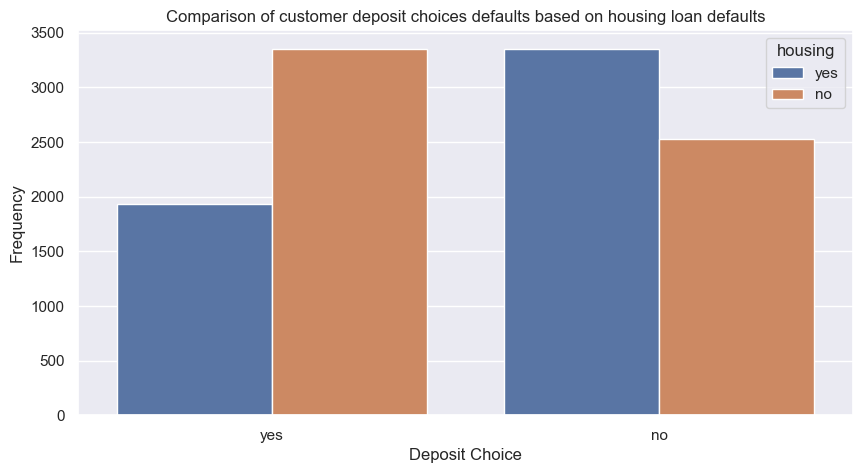

In [40]:
# Deposit choice and housing loan defaults


plt.figure(figsize = (10, 5))

sns.countplot(data = data, x = "deposit", hue = "housing")

plt.title("Comparison of customer deposit choices defaults based on housing loan defaults")

plt.xlabel("Deposit Choice")
plt.ylabel("Frequency")

#plt.legend(title = "Age Category")
plt.show(); plt.close("all")


Customer occupation with respect to their educational level

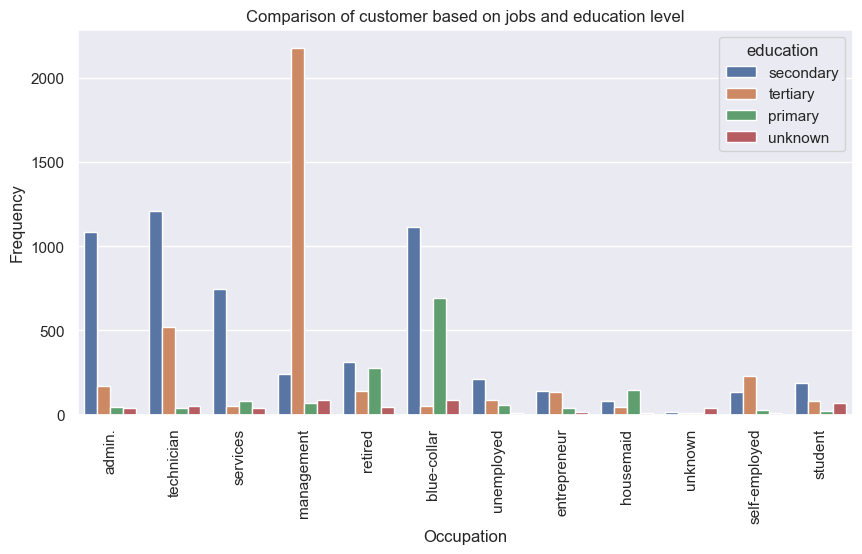

In [42]:
# Occupation wrt education


plt.figure(figsize = (10, 5))

sns.countplot(data = data, x = "job", hue = "education")

plt.title("Comparison of customer based on jobs and education level")

plt.xlabel("Occupation")
plt.ylabel("Frequency")

plt.xticks(rotation = 90)


#plt.legend(title = "Age Category")
plt.show(); plt.close("all")


Customer occupation with respect to their deposit choices

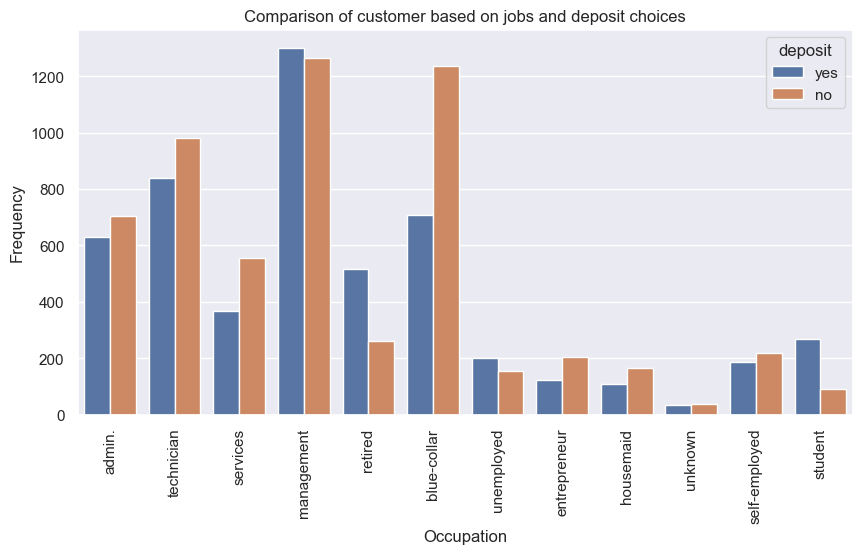

In [45]:
# Occupation wrt education


plt.figure(figsize = (10, 5))

sns.countplot(data = data, x = "job", hue = "deposit")

plt.title("Comparison of customer based on jobs and deposit choices")

plt.xlabel("Occupation")
plt.ylabel("Frequency")

plt.xticks(rotation = 90)


#plt.legend(title = "Age Category")
plt.show(); plt.close("all")


Comparism between customer decisions in previous campaign vs present campaign

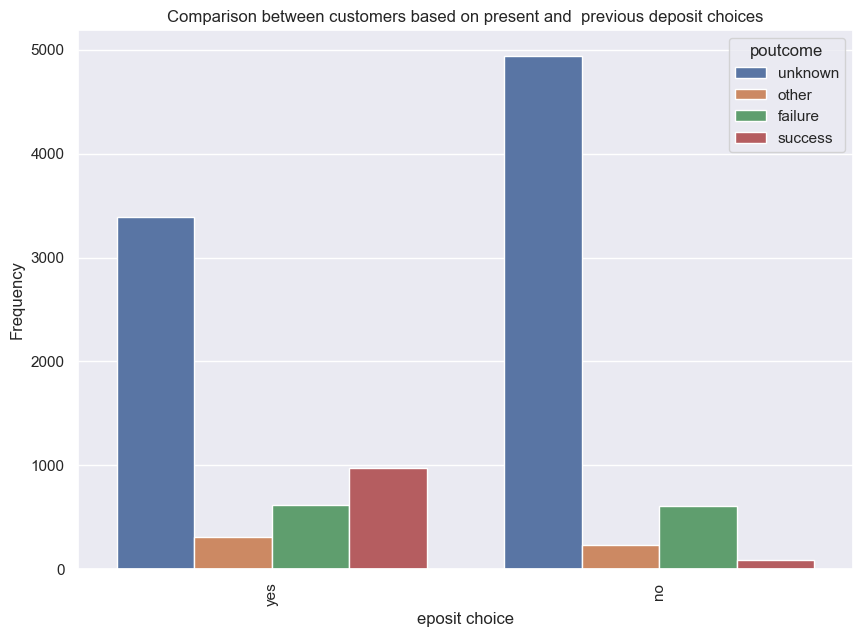

In [47]:
# deposit choice by previous outcome


plt.figure(figsize = (10, 7))

sns.countplot(data = data, x = "deposit", hue = "poutcome")

plt.title("Comparison between customers based on present and  previous deposit choices")

plt.xlabel("eposit choice")
plt.ylabel("Frequency")

plt.xticks(rotation = 90)


#plt.legend(title = "Age Category")
plt.show(); plt.close("all")


Customer deposit decision based on inter-camppaign telemarketing call interval

In [49]:
# extract successful segment
success = data[data["deposit"] == "yes"]

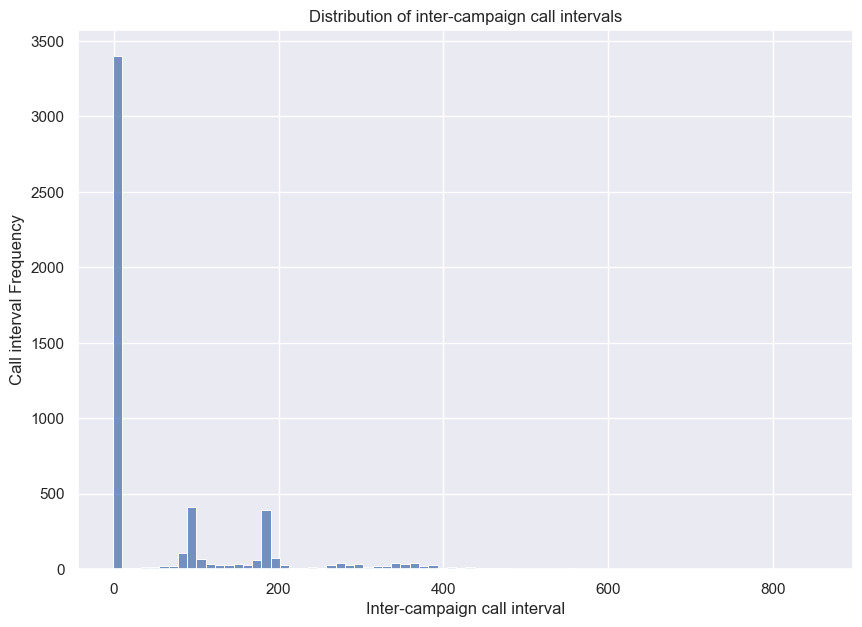

In [50]:
# deposit choice by previous outcome


plt.figure(figsize = (10, 7))

sns.histplot(data = success, x = "pdays")

plt.title("Distribution of inter-campaign call intervals")

plt.xlabel("Inter-campaign call interval")
plt.ylabel("Call interval Frequency")


#plt.legend(title = "Age Category")
plt.show(); plt.close("all")


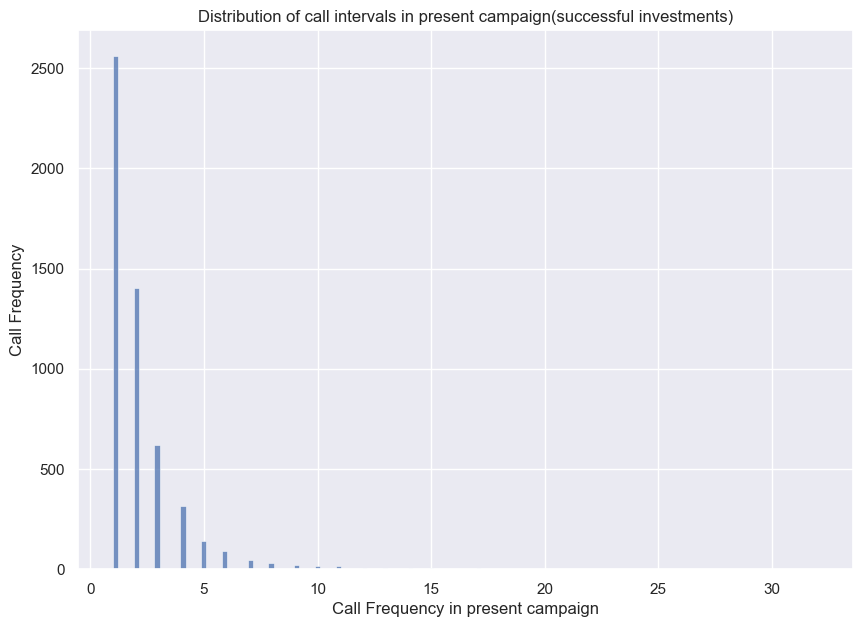

In [51]:
# call intervals in present campaign


plt.figure(figsize = (10, 7))

sns.histplot(data = success, x = "campaign")

plt.title("Distribution of call intervals in present campaign(successful investments)")

plt.xlabel("Call Frequency in present campaign")
plt.ylabel("Call Frequency")


#plt.legend(title = "Age Category")
plt.show(); plt.close("all")


In [52]:
# Extract successful deposit sunset from previous campaign
previous_success = data.loc[data["poutcome"] == "success"]
previous_success

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
899,56,technician,married,secondary,no,589,yes,no,unknown,23,oct,518,1,147,2,success,yes
951,53,retired,married,tertiary,no,2269,no,no,cellular,17,nov,1091,2,150,1,success,yes
985,46,unemployed,divorced,secondary,no,3354,yes,no,cellular,19,nov,522,1,174,1,success,yes
994,40,management,married,tertiary,no,3352,yes,no,cellular,19,nov,639,2,27,1,success,yes
1151,31,management,married,tertiary,no,1331,no,no,cellular,3,feb,182,2,90,1,success,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10798,67,technician,married,secondary,no,0,no,no,cellular,13,aug,1152,2,188,1,success,no
10911,33,technician,married,secondary,no,348,yes,no,cellular,7,may,263,2,294,1,success,no
10918,36,entrepreneur,single,tertiary,no,145,yes,no,cellular,18,may,450,2,304,2,success,no
11069,33,self-employed,single,tertiary,no,658,yes,no,cellular,12,apr,93,1,173,2,success,no


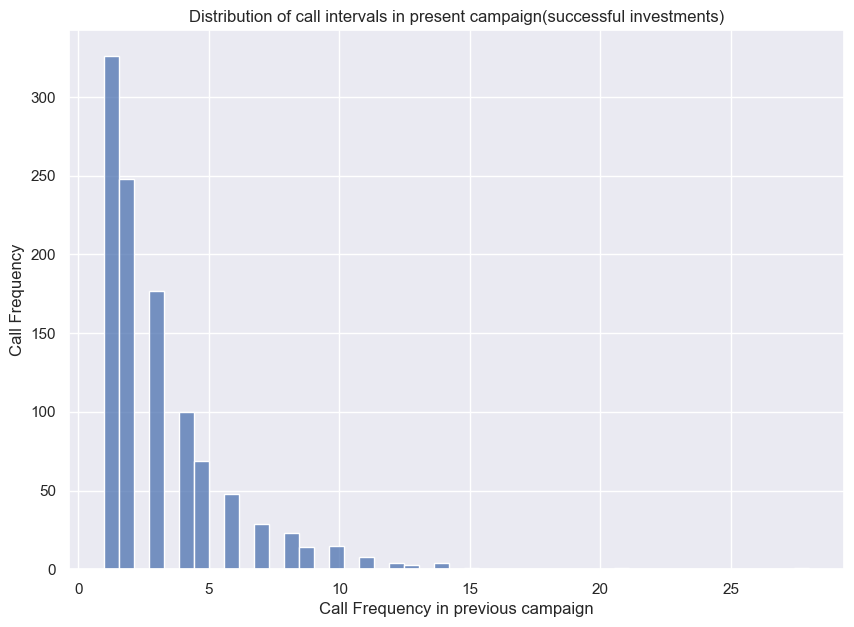

In [53]:
# Distribution of call frequencies in previous campaign

plt.figure(figsize = (10, 7))

sns.histplot(data = previous_success, x = "previous")

plt.title("Distribution of call intervals in present campaign(successful investments)")

plt.xlabel("Call Frequency in previous campaign")
plt.ylabel("Call Frequency")


#plt.legend(title = "Age Category")
plt.show(); plt.close("all")


Inter-campaign call interval with respect to previous deposit outcome

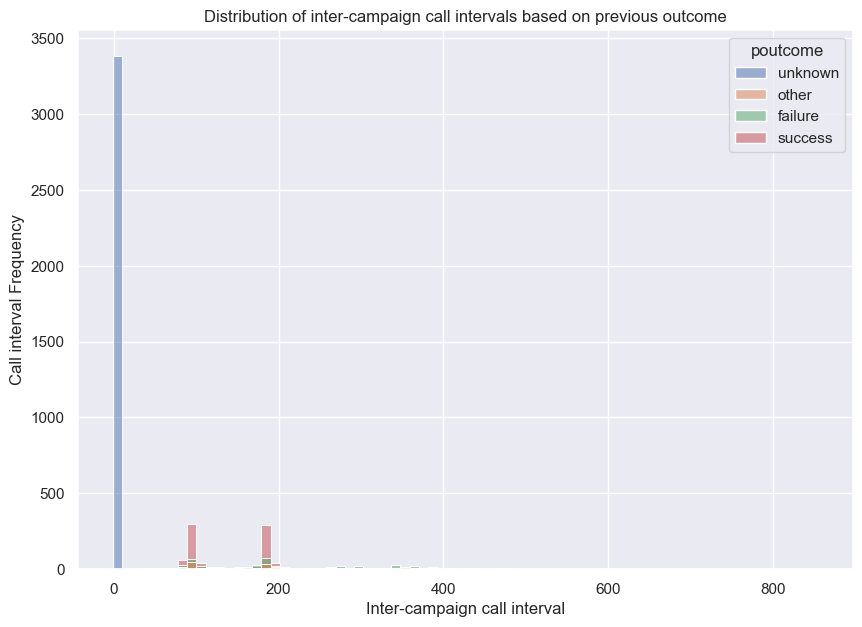

In [55]:
# Distribution of inter-campaign call intervals based on previous outcome

plt.figure(figsize = (10, 7))

sns.histplot(data = success, x = "pdays", hue = "poutcome")

plt.title("Distribution of inter-campaign call intervals based on previous outcome")

plt.xlabel("Inter-campaign call interval")
plt.ylabel("Call interval Frequency")


#plt.legend(title = "Age Category")
plt.show(); plt.close("all")


Customer deposit decision and call duration

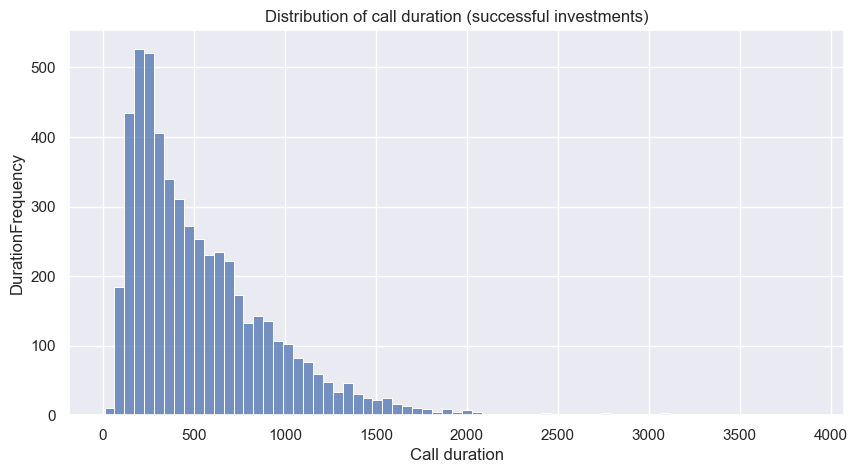

In [57]:
# Distribution of call duration for successful deposits

plt.figure(figsize = (10, 5))

sns.histplot(data = success, x = "duration")

plt.title("Distribution of call duration (successful investments)")

plt.xlabel("Call duration")
plt.ylabel("DurationFrequency")


#plt.legend(title = "Age Category")
plt.show(); plt.close("all")


Label imbalance

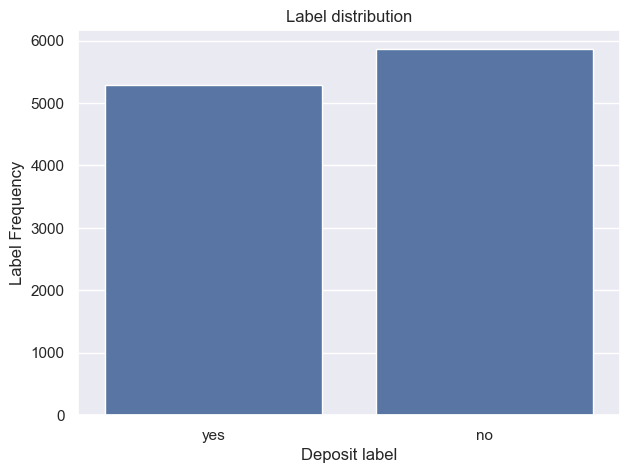

In [59]:
# Distribution of labels


plt.figure(figsize = (7, 5))

sns.countplot(data = data, x = "deposit")

plt.title("Label distribution")

plt.xlabel("Deposit label")
plt.ylabel("Label Frequency")


#plt.legend(title = "Age Category")
plt.show(); plt.close("all")


In [60]:
data["deposit"].value_counts(normalize = True)

deposit
no     0.52616
yes    0.47384
Name: proportion, dtype: float64

In [61]:
# Feature correlation
correlation = data.select_dtypes("number").corr()

In [62]:
correlation

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.112300,-0.000762,0.000189,-0.005278,0.002774,0.020169
balance,0.112300,1.000000,0.010467,0.022436,-0.013894,0.017411,0.030805
day,-0.000762,0.010467,1.000000,-0.018511,0.137007,-0.077232,-0.058981
duration,0.000189,0.022436,-0.018511,1.000000,-0.041557,-0.027392,-0.026716
campaign,-0.005278,-0.013894,0.137007,-0.041557,1.000000,-0.102726,-0.049699
pdays,0.002774,0.017411,-0.077232,-0.027392,-0.102726,1.000000,0.507272
previous,0.020169,0.030805,-0.058981,-0.026716,-0.049699,0.507272,1.000000


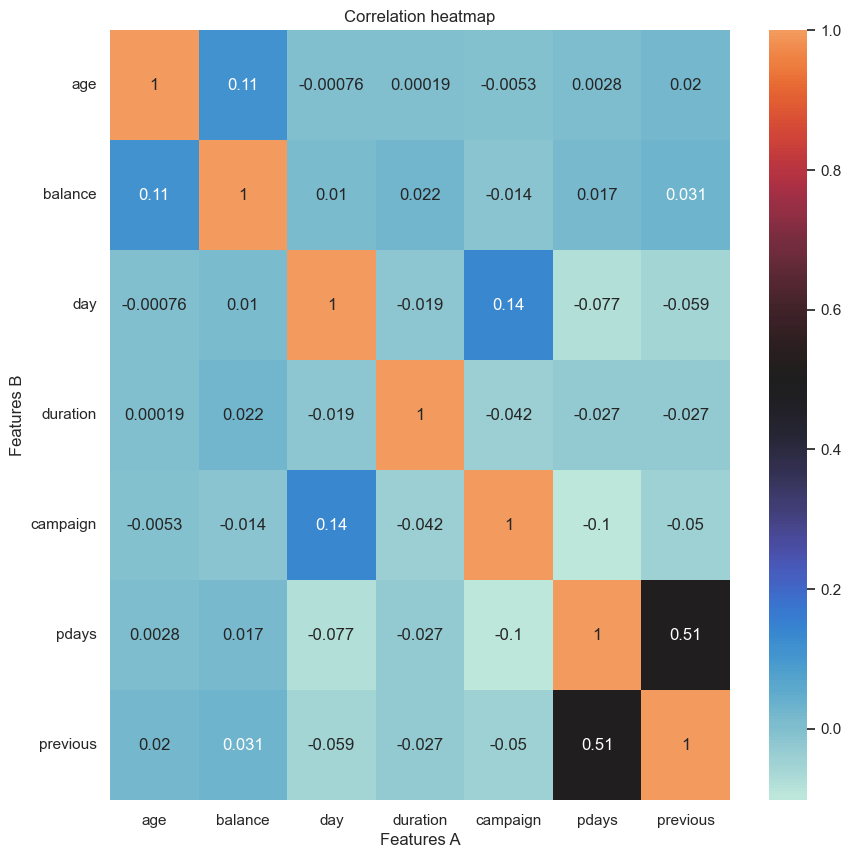

In [63]:
#correlation heatmap

plt.figure(figsize = (10, 10))

sns.heatmap(correlation, center = .5,annot = True)

plt.title("Correlation heatmap")

plt.xlabel("Features A")
plt.ylabel("Features B")

plt.yticks(rotation = 90*4)
#plt.xticks(rotation = 90)

plt.show(); plt.close("all")

In [64]:
#correlation of target variable with independent variables

target = data["deposit"].apply(lambda x: 1 if x == "yes" else 0)
data.select_dtypes(exclude=["object"]).corrwith(target, method="spearman")

age        -0.012156
balance     0.157584
day        -0.058325
duration    0.527801
campaign   -0.126666
pdays       0.212805
previous    0.229905
dtype: float64

### Data *Preparation*

In [66]:
from sklearn.model_selection import train_test_split


In [67]:
categorical_features = data.select_dtypes("object").columns.to_list()
scale_features = [
    "age",
    "balance",
    "day",
    "duration"
]
categorical_features.remove("deposit")

In [68]:
# Get features and targets
X, y = data.drop("deposit", axis = 1), data["deposit"]

In [69]:
# Encode target
map_dictionary = {"yes": 1, "no": 0}
y = y.map(map_dictionary)

In [70]:
# Get train and teat splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

### Data Modelling

In [73]:
!pip install catboost

In [74]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

In [75]:
def get_transformers(categorical_features, scale_features, one_hot = False):
    if one_hot:
        encoder = ColumnTransformer(
            transformers = [
                ("one_hot", OneHotEncoder(), categorical_features),
                ("scale", StandardScaler(), scale_features)
            ],
            remainder = "passthrough"
        )
    else:
        encoder = ColumnTransformer(
            transformers = [
                ("ordinal", OrdinalEncoder(), categorical_features),
                ("scale", StandardScaler(), scale_features)
            ],
            remainder = "passthrough"
        )
    return encoder

In [76]:
# Instantiate models
log_pipe = Pipeline(
    steps = [
        ("!", get_transformers(categorical_features, scale_features, one_hot = True)),
        ("2", LogisticRegression(max_iter = 1000))
    ]
)
cat_pipe = Pipeline(
    steps = [
        ("!", get_transformers(categorical_features, scale_features, one_hot = False)),
        ("2", CatBoostClassifier(verbose = 0))
    ]
)

extra_pipe = Pipeline(
    steps = [
        ("!", get_transformers(categorical_features, scale_features, one_hot = False)),
        ("2", ExtraTreesClassifier())
    ]
)

In [77]:
#Fit Logistic model
log_pipe.fit(X_train, y_train)

Pipeline(steps=[('!',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot', OneHotEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome']),
                                                 ('scale', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration'])])),
                ('2', LogisticRegression(max_iter=1000))])

In [78]:
# Fit CatBoost model
cat_pipe.fit(X_train, y_train)


Pipeline(steps=[('!',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal', OrdinalEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome']),
                                                 ('scale', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration'])])),
                ('2',
                 <catboost.core.CatBoostClassifier object at 0x000001FD0E1FF380>)])

In [79]:
# Fit ExtraTrees model
extra_pipe.fit(X_train, y_train)

Pipeline(steps=[('!',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal', OrdinalEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome']),
                                                 ('scale', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration'])])),
                ('2', ExtraTreesClassifier())])

### Model Evaluation

In [81]:
from sklearn.metrics import classification_report

In [82]:
# def test_model(model, data):
#   train, test = data
#   X_train, y_train = train
#   X_test, y_test = test

#   train_results = classification_report(y_train, model.predict(X_train))
#   test_results = classification_report(y_test, model.predict(X_test))

#   print("="*30, "Train Report", "="*30)
#   print(train_results)

#   print("="*30, "Test Report", "="*30)
#   print(test_results)

#   return

In [83]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from mlflow.models.signature import infer_signature
import mlflow
import mlflow.sklearn

def test_model(model, data, run_name="default_run"):
    train, test = data
    X_train, y_train = train
    X_test, y_test = test

    mlflow.set_experiment("long_term_investor_detection")

    with mlflow.start_run(run_name=run_name):
        # Train model
        model.fit(X_train, y_train)

        # Predict
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        y_proba_test = model.predict_proba(X_test)[:, 1]

        # Print classification reports (your format)
        print("=" * 30, "Train Report", "=" * 30)
        train_results = classification_report(y_train, y_pred_train)
        print(train_results)

        print("=" * 30, "Test Report", "=" * 30)
        test_results = classification_report(y_test, y_pred_test)
        print(test_results)

        # Log metrics
        acc = accuracy_score(y_test, y_pred_test)
        prec = precision_score(y_test, y_pred_test)
        rec = recall_score(y_test, y_pred_test)
        f1 = f1_score(y_test, y_pred_test)

        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)

        # Log model with signature + input sample
        input_example = X_test.iloc[:5]
        signature = infer_signature(input_example, model.predict(input_example))

        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path=f"{run_name}_model",
            input_example=input_example,
            signature=signature
        )


In [84]:
# Accumulate data fro teating
data_= [
    (X_train, y_train),
    (X_test, y_test)
]

In [85]:
# Test Logistic model
test_model(log_pipe, data_, run_name="logistic_regression")

============================== Train Report ==============================
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      4111
           1       0.83      0.79      0.81      3702

    accuracy                           0.82      7813
   macro avg       0.82      0.82      0.82      7813
weighted avg       0.82      0.82      0.82      7813

============================== Test Report ==============================
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1762
           1       0.83      0.80      0.81      1587

    accuracy                           0.83      3349
   macro avg       0.83      0.82      0.83      3349
weighted avg       0.83      0.83      0.83      3349



In [86]:
# Test CatBoost model
test_model(cat_pipe, data_, run_name="catboost")

============================== Train Report ==============================
              precision    recall  f1-score   support

           0       0.94      0.89      0.92      4111
           1       0.89      0.93      0.91      3702

    accuracy                           0.91      7813
   macro avg       0.91      0.91      0.91      7813
weighted avg       0.91      0.91      0.91      7813

============================== Test Report ==============================
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1762
           1       0.84      0.88      0.86      1587

    accuracy                           0.86      3349
   macro avg       0.86      0.86      0.86      3349
weighted avg       0.86      0.86      0.86      3349



In [87]:
# Test ExtraTrees model
test_model(extra_pipe, data_, run_name="extra_trees")

============================== Train Report ==============================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4111
           1       1.00      1.00      1.00      3702

    accuracy                           1.00      7813
   macro avg       1.00      1.00      1.00      7813
weighted avg       1.00      1.00      1.00      7813

============================== Test Report ==============================
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1762
           1       0.82      0.84      0.83      1587

    accuracy                           0.84      3349
   macro avg       0.84      0.84      0.84      3349
weighted avg       0.84      0.84      0.84      3349



#### Hyperparameter Tunning

In [89]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold

In [90]:
# Instantiate models
new_log_pipe = Pipeline(
    steps = [
        ("!", get_transformers(categorical_features, scale_features, one_hot = True)),
        ("2", LogisticRegression(max_iter = 1000))
    ]
)
new_cat_pipe = Pipeline(
    steps = [
        ("!", get_transformers(categorical_features, scale_features, one_hot = False)),
        ("2", CatBoostClassifier(verbose = 0))
    ]
)

In [91]:
# # Instanstiate hyperparameter grid
# cat_grid_params = {
#     "2__sampling_frequency":
#     ["PerTree", "PerTreeLevel"],
#     "2__l2_leaf_reg": [.0, .1, .2, .3, .4, .5],
# }


# Change to
cat_grid_params = {
    "2__sampling_frequency":
    ["PerTree", "PerTreeLevel"],
    "2__l2_leaf_reg": [.0, .1, .2, .3, .4, .5]
}

log_grid_params = {
    "2__penalty": ["l1", "l2", "elasticnet", None],
    "2__C": [1., 2., 3., 4.]
}



In [92]:
# Instanstiate grid object
log_grid = GridSearchCV(
    estimator = new_log_pipe,
    param_grid = log_grid_params,
    scoring = "accuracy",
    cv = RepeatedKFold(n_splits = 2, n_repeats = 3)
)

cat_grid = GridSearchCV(
    estimator = new_cat_pipe,
    param_grid = cat_grid_params,
    scoring = "accuracy",
    cv = RepeatedKFold(n_splits = 2, n_repeats = 3)
)


In [93]:
log_grid.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=2, random_state=None),
             estimator=Pipeline(steps=[('!',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one_hot',
                                                                         OneHotEncoder(),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'poutcome']),
                                                                        ('scale',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'balance',
                                                                          'day',
                                                                          'duration'])])),
                                       ('2',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'2__C': [1.0, 2.0, 3.0, 4.0],
                         '2__penalty': ['l1', 'l2', 'elasticnet', None]},
             scoring='accuracy')

In [94]:
# cat_grid_params = {
#     "2__sampling_frequency":
#     ["PerTree", "PerTreeLevel"],
#     # The key was incorrect. Changed from "12_leaf_reg" to "2__l2_leaf_reg" to correctly reference the CatBoostClassifier in the pipeline.
#     "2__l2_leaf_reg": [.0, .1, .2, .3, .4, .5]
# }

# log_grid_params = {
#     "2__penalty": ["l1", "l2", "elasticnet", None],
#     "2__C": [1., 2., 3., 4.]
# }

In [95]:
cat_grid.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=2, random_state=None),
             estimator=Pipeline(steps=[('!',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'poutcome']),
                                                                        ('scale',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'balance',
                                                                          'day',
                                                                          'duration'])])),
                                       ('2',
                                        <catboost.core.CatBoostClassifier object at 0x000001FD16119AF0>)]),
             param_grid={'2__l2_leaf_reg': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                         '2__sampling_frequency': ['PerTree', 'PerTreeLevel']},
             scoring='accuracy')

In [97]:
# Test best CatBoost from grid
test_model(cat_grid.best_estimator_, data_)

============================== Train Report ==============================
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      4111
           1       0.92      0.95      0.93      3702

    accuracy                           0.93      7813
   macro avg       0.93      0.93      0.93      7813
weighted avg       0.93      0.93      0.93      7813

============================== Test Report ==============================
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1762
           1       0.84      0.88      0.86      1587

    accuracy                           0.86      3349
   macro avg       0.86      0.86      0.86      3349
weighted avg       0.87      0.86      0.86      3349



In [98]:
# Test best Logistic from grid
test_model(log_grid.best_estimator_, data_)

============================== Train Report ==============================
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      4111
           1       0.83      0.79      0.81      3702

    accuracy                           0.82      7813
   macro avg       0.82      0.82      0.82      7813
weighted avg       0.82      0.82      0.82      7813

============================== Test Report ==============================
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1762
           1       0.83      0.80      0.81      1587

    accuracy                           0.83      3349
   macro avg       0.83      0.82      0.83      3349
weighted avg       0.83      0.83      0.83      3349



In [99]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


In [100]:
import shap

catboost_model = cat_pipe.named_steps["2"]



In [101]:
# Apply the preprocessing step manually to the test set
X_test_transformed = cat_pipe.named_steps["!"].transform(X_test)


In [242]:
# Get transformed column names
transformed_feature_names = cat_pipe.named_steps["!"].get_feature_names_out(X_test.columns)

# Clean the feature names (remove 'scale__', 'ordinal__', 'remainder__')
transformed_feature_names = [name.split("__")[-1] for name in transformed_feature_names]

import pandas as pd
X_test_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names)



In [244]:
import shap

# Create TreeExplainer for CatBoost
explainer = shap.TreeExplainer(catboost_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_df)



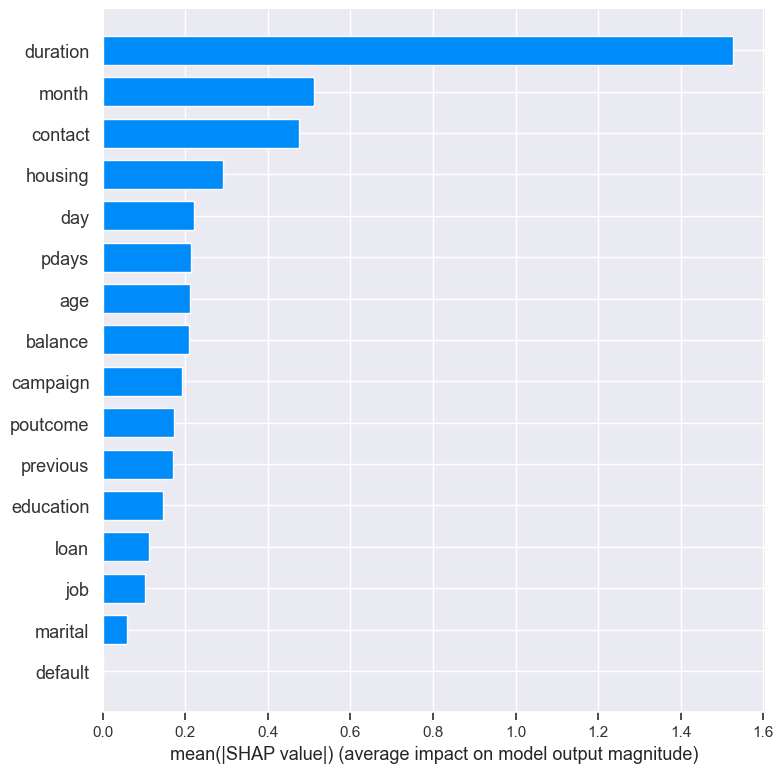

In [245]:
shap.summary_plot(shap_values, X_test_df, plot_type="bar")



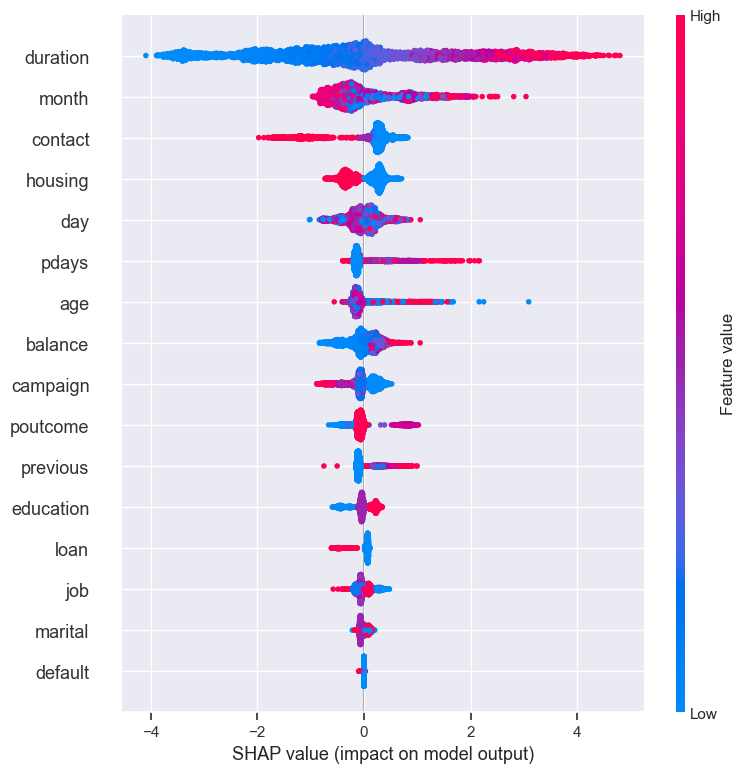

In [246]:
shap.summary_plot(shap_values, X_test_df)


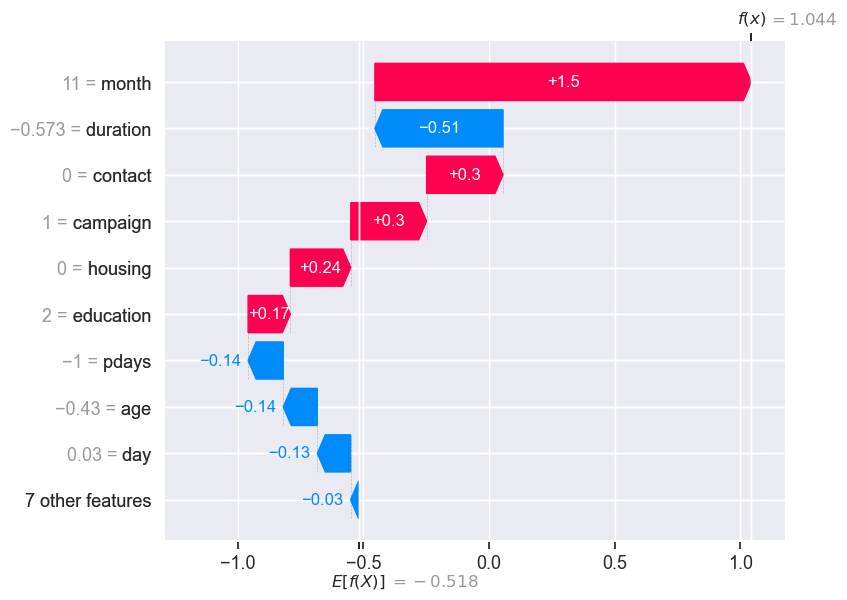

In [250]:
shap.initjs()
shap.plots.waterfall(shap.Explanation(values=shap_values[0],
                                      base_values=explainer.expected_value,
                                      data=X_test_df.iloc[0]))


In [107]:
# import mlflow
# import mlflow.sklearn  # works for CatBoost too via generic interface

# mlflow.set_experiment("long_term_investor_detection")


In [108]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# with mlflow.start_run(run_name="catboost_baseline"):
#     # Fit model
#     cat_pipe.fit(X_train, y_train)

#     # Predict
#     y_pred = cat_pipe.predict(X_test)

#     # Metrics
#     acc = accuracy_score(y_test, y_pred)
#     prec = precision_score(y_test, y_pred)
#     rec = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)

#     # Log metrics
#     mlflow.log_metric("accuracy", acc)
#     mlflow.log_metric("precision", prec)
#     mlflow.log_metric("recall", rec)
#     mlflow.log_metric("f1_score", f1)

#     # Log model
#     #mlflow.sklearn.log_model(cat_pipe, "catboost_pipeline_model")


In [109]:
# from mlflow.models.signature import infer_signature

# # Use part of test data for example input
# input_example = X_test.iloc[:5]

# # Get predictions for that input
# example_preds = cat_pipe.predict(input_example)

# # Infer signature from inputs and outputs
# signature = infer_signature(input_example, example_preds)

# # Now log the model with extra info
# mlflow.sklearn.log_model(
#     cat_pipe,
#     artifact_path="catboost_pipeline_model",
#     signature=signature,
#     input_example=input_example
# )


In [110]:
print("✅ Model and metrics logged to MLflow!")

✅ Model and metrics logged to MLflow!


In [111]:
#!mlflow ui --port 5000

In [112]:
import mlflow
mlflow.set_tracking_uri("http://localhost:5000")


In [113]:
# !pip install mlflow pyngrok


In [114]:
# !ngrok config add-authtoken 2l4QSGrzXD1h4pvR6THv8I9nEEz_71CCH9kZBwRgVfsZ6FSZX


In [115]:
# import mlflow
# from pyngrok import ngrok

# # Set up MLflow tracking URI to local folder
# mlflow.set_tracking_uri("file:/content/mlruns")

# # Start the MLflow UI
# get_ipython().system_raw("mlflow ui --port 5000 &")

# # Open an ngrok tunnel to the MLflow UI
# mlflow_url = ngrok.connect(5000)
# print(f"MLflow UI is live at: {mlflow_url}")


In [116]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.


In [117]:
# %%writefile app.py
# import streamlit as st
# import pandas as pd
# import mlflow.sklearn
# import shap
# import matplotlib.pyplot as plt

# # ====== LOAD MODEL FROM MLFLOW ======
# run_id = "7e7edbfec7c6489d9965aa803cddd396"  # <- Replace with actual run ID from MLflow
# model_uri = f"runs:/{run_id}/catboost_model"  # match the name used in log_model()
# model = mlflow.sklearn.load_model(model_uri)

# st.title("📈 Long-Term Investor Prediction App")
# st.write("Enter client information below:")

# # ====== USER INPUT FORM ======
# job = st.selectbox("Job", [
#     "admin.", "technician", "services", "management", "retired", 
#     "blue-collar", "unemployed", "entrepreneur", "housemaid", 
#     "self-employed", "student", "unknown"
# ])

# marital = st.selectbox("Marital Status", ["married", "single", "divorced"])
# education = st.selectbox("Education", ["primary", "secondary", "tertiary", "unknown"])
# default = st.selectbox("Default Credit?", ["yes", "no"])
# housing = st.selectbox("Housing Loan?", ["yes", "no"])
# loan = st.selectbox("Personal Loan?", ["yes", "no"])
# contact = st.selectbox("Contact Type", ["cellular", "telephone", "unknown"])
# month = st.selectbox("Last Contact Month", [
#     "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"
# ])
# poutcome = st.selectbox("Previous Campaign Outcome", ["success", "failure", "other", "unknown"])

# # ===== Numeric fields =====
# age = st.slider("Age", 18, 100, 35)
# balance = st.number_input("Balance", value=1000)
# day = st.slider("Last Contact Day", 1, 31, 15)
# duration = st.slider("Call Duration (seconds)", 0, 5000, 250)
# campaign = st.slider("Number of Contacts (campaign)", 1, 50, 2)
# pdays = st.number_input("Days Since Last Contact", value=999)
# previous = st.number_input("Previous Contacts", value=0)


# # ====== PREP INPUT DATAFRAME ======
# input_data = pd.DataFrame([{
#     "age": age,
#     "job": job,
#     "marital": marital,
#     "education": education,
#     "default": default,
#     "balance": balance,
#     "housing": housing,
#     "loan": loan,
#     "contact": contact,
#     "day": day,
#     "month": month,
#     "duration": duration,
#     "campaign": campaign,
#     "pdays": pdays,
#     "previous": previous,
#     "poutcome": poutcome
# }])

# # ====== MAKE PREDICTION ======
# if st.button("Predict"):
#     prediction = model.predict(input_data)[0]
#     probability = model.predict_proba(input_data)[0][1]

#     st.subheader("Prediction:")
#     st.write("✅ YES — Likely to deposit" if prediction == 1 else "❌ NO — Unlikely to deposit")
#     st.write(f"Confidence: {probability:.2%}")

# # ===== SHAP Explanation =====
# if st.button("Predict", key="predict_button"):
#     prediction = model.predict(input_data)[0]
#     probability = model.predict_proba(input_data)[0][1]

#     st.subheader("🔮 Prediction Result")
#     st.write("Prediction:", "✅ YES — Likely to deposit" if prediction == 1 else "❌ NO — Unlikely to deposit")
#     st.write(f"Confidence: {probability:.2%}")

In [118]:
%%writefile app.py
import streamlit as st
import pandas as pd
import mlflow.sklearn

# ====== CUSTOM PAGE CONFIG ======
st.set_page_config(
    page_title="Long-Term Investor Predictor",
    layout="centered",
    initial_sidebar_state="auto"
)

# ====== CUSTOM DARK THEME STYLE ======
st.markdown("""
    <style>
    body {
        background-color: #1e1e1e;
        color: #f0f0f0;
    }
    .stApp {
        background-color: #1e1e1e;
        color: #f0f0f0;
    }
    .stButton>button {
        background-color: #444444;
        color: white;
        border-radius: 5px;
    }
    .stSelectbox label, .stNumberInput label {
        color: #f0f0f0 !important;
    }
    .footer {
        position: fixed;
        bottom: 0;
        width: 100%;
        text-align: center;
        font-size: 13px;
        color: #999999;
        padding: 10px;
    }
    .footer a {
        color: #bbbbbb;
        margin: 0 8px;
    }
    </style>
""", unsafe_allow_html=True)

# ====== LOAD MODEL ======
run_id = "7e7edbfec7c6489d9965aa803cddd396"
model_uri = f"runs:/{run_id}/catboost_model"
model = mlflow.sklearn.load_model(model_uri)

# ====== APP HEADER ======
st.title("Long-Term Investor Prediction")
st.markdown("Enter Client Information.")

# ====== CATEGORICAL INPUTS ======
job = st.selectbox("Job", [
    "admin.", "technician", "services", "management", "retired", 
    "blue-collar", "unemployed", "entrepreneur", "housemaid", 
    "self-employed", "student", "unknown"
])
marital = st.selectbox("Marital Status", ["married", "single", "divorced"])
education = st.selectbox("Education", ["primary", "secondary", "tertiary", "unknown"])
default = st.selectbox("Default Credit?", ["yes", "no"])
housing = st.selectbox("Housing Loan?", ["yes", "no"])
loan = st.selectbox("Personal Loan?", ["yes", "no"])
contact = st.selectbox("Contact Type", ["cellular", "telephone", "unknown"])
month = st.selectbox("Last Contact Month", [
    "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", 
    "sep", "oct", "nov", "dec"
])
poutcome = st.selectbox("Previous Campaign Outcome", ["success", "failure", "other", "unknown"])

# ====== NUMERIC INPUTS ======
age = st.number_input("Age", min_value=18, max_value=100, value=35)
balance = st.number_input("Account Balance (€)", value=1000)
day = st.number_input("Last Contact Day", min_value=1, max_value=31, value=15)
duration = st.number_input("Call Duration (sec)", min_value=0, max_value=5000, value=250)
campaign = st.number_input("Contacts During Campaign", min_value=1, max_value=50, value=2)
pdays = st.number_input("Days Since Last Contact", value=999)
previous = st.number_input("Previous Campaign Contacts", value=0)

# ====== PREPARE DATAFRAME ======
input_data = pd.DataFrame([{
    "age": age,
    "job": job,
    "marital": marital,
    "education": education,
    "default": default,
    "balance": balance,
    "housing": housing,
    "loan": loan,
    "contact": contact,
    "day": day,
    "month": month,
    "duration": duration,
    "campaign": campaign,
    "pdays": pdays,
    "previous": previous,
    "poutcome": poutcome
}])

# ====== PREDICT ======
if st.button("Predict Now"):
    prediction = model.predict(input_data)[0]
    probability = model.predict_proba(input_data)[0][1]

    st.subheader("Prediction Result")
    st.success("✅ YES — Likely to deposit" if prediction == 1 else "❌ NO — Unlikely to deposit")
    st.write(f"**Confidence Score:** {probability:.2%}")

# ====== FOOTER ======
# st.markdown("""
#     <style>
#     .footer {
#         position: fixed;
#         bottom: 0;
#         left: 0;
#         right: 0;
#         background: #1e1e1e;
#         text-align: center;
#         padding: 12px 0;
#         font-size: 14px;
#         font-weight: bold;
#         color: #d4bfff;
#     }
#     .footer a {
#         color: #f0a500;
#         text-decoration: none;
#         margin: 0 10px;
#     }
#     .footer a:hover {
#         text-decoration: underline;
#     }
#     </style>

#     <div class="footer">
#         Developed by Oluwakemi – ©2025<br>
#         <a href="https://www.linkedin.com/in/oluwakemi-sorinmade/" target="_blank">LinkedIn</a>
#         <a href="https://github.com/Olukem" target="_blank">GitHub</a>
#     </div>
# """, unsafe_allow_html=True)

st.markdown("""
    <style>
    @import url('https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.4.0/css/all.min.css');

    .footer {
        position: fixed;
        bottom: 0;
        left: 0;
        right: 0;
        background: #1e1e1e;
        text-align: center;
        padding: 10px 0;
        font-size: 14px;
        font-weight: bold;
        color: #d4bfff;
        z-index: 100;
    }
    .footer a {
        color: #d4bfff; /* Match text color */
        text-decoration: none;
        margin: 0 15px;
        font-size: 20px;
    }
    .footer a:hover {
        color: white;
    }
    </style>

    <div class="footer">
        Developed by Oluwakemi – ©2025<br>
        <a href="https://www.linkedin.com/in/oluwakemi-sorinmade/" target="_blank">
            <i class="fab fa-linkedin"></i>
        </a>
        <a href="https://github.com/Olukem" target="_blank">
            <i class="fab fa-github"></i>
        </a>
    </div>
""", unsafe_allow_html=True)


Overwriting app.py
